https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html

In [1]:
import time

import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from geomloss import SamplesLoss
from sklearn.metrics import pairwise_distances

In [2]:
def load_image(filename):
    img = iio.imread(filename)
    return img / 255.0


def RGB_cloud(filename, sampling, dtype=torch.FloatTensor, start=1):
    A = load_image(filename)
    A = A[start::sampling, ::sampling, :]  # avoid appearing purple-like line
    return torch.from_numpy(A).type(dtype).view(-1, 3)


def display_image(ax, x):
    W = int(np.sqrt(len(x)))
    x_ = x.view(W, W, 3).detach().cpu().numpy()
    ax.imshow(x_)


def display_cloud(ax, x):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=25 * 500 / len(x_), c=x_)

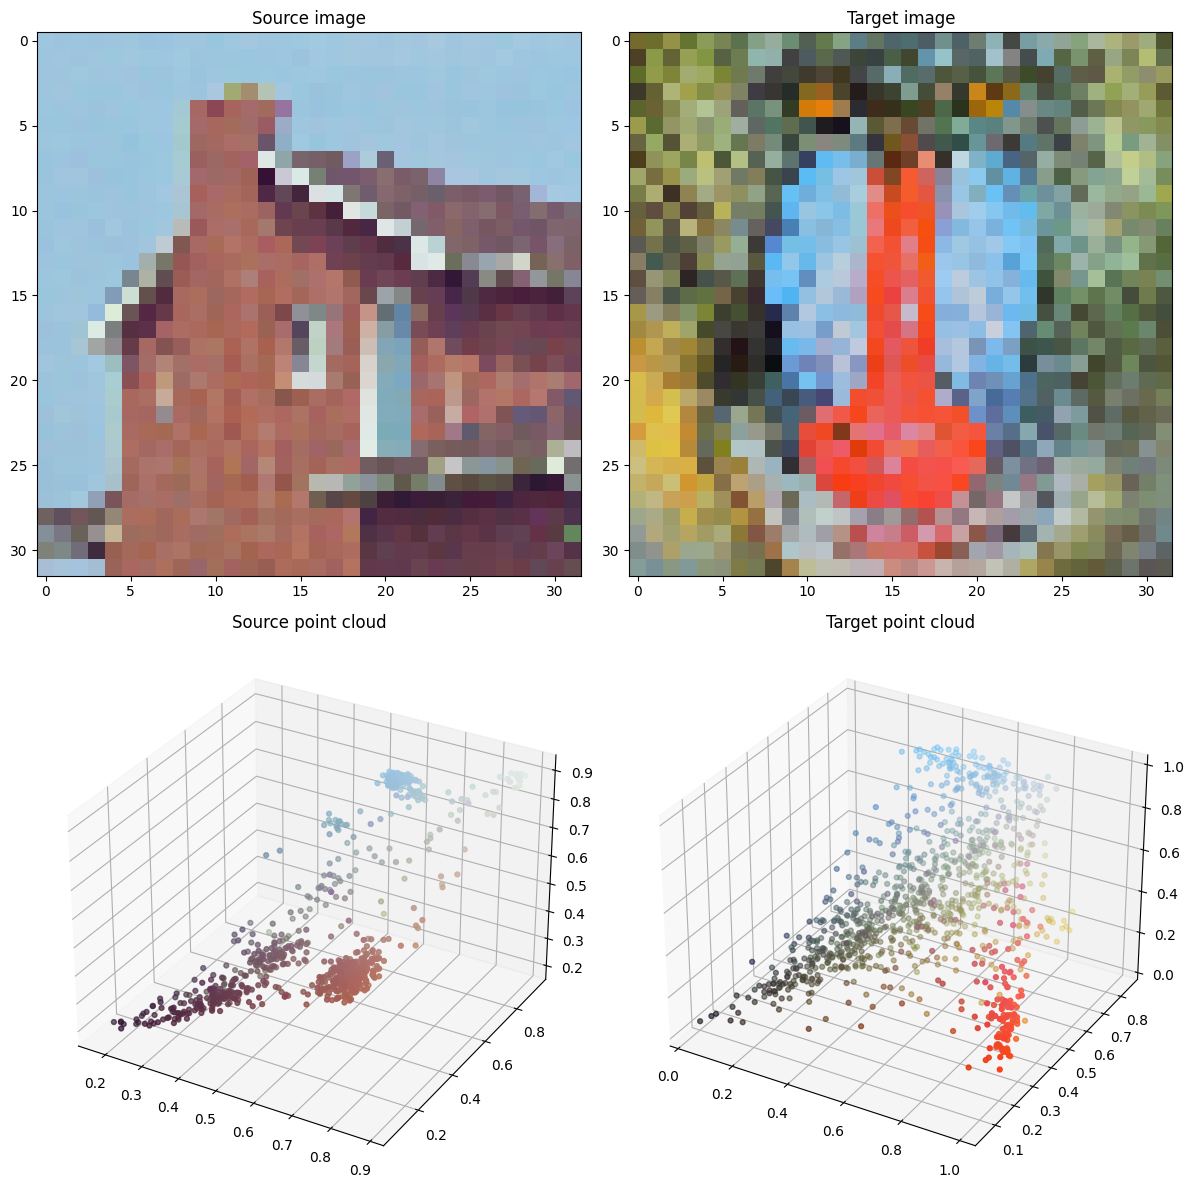

In [3]:
use_cuda = torch.cuda.is_available()
sampling = 8 if not use_cuda else 1
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

X_i = RGB_cloud("../data/house_256.png", sampling, dtype)  # (w//8*h//8, 3)
Y_j = RGB_cloud("../data/mandrill_256.png", sampling, dtype)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
display_image(ax, X_i)
ax.set_title("Source image")
ax = fig.add_subplot(2, 2, 2)
display_image(ax, Y_j)
ax.set_title("Target image")

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, X_i)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, Y_j)
ax.set_title("Target point cloud")
plt.tight_layout()

In [4]:
lr = 1.0

x_i = X_i.clone()
x_i.requires_grad = True
y_j = Y_j.clone()
print(x_i)
# print(f"grad: {x_i.grad}")

# optimizer = optim.SGD([x_i], lr=lr)
loss_fn = SamplesLoss("sinkhorn", blur=0.3)

loss = loss_fn(x_i, y_j)
# optimizer.zero_grad()
loss.backward()
# print(x_i)
# print(f"grad: {x_i.grad}")
# optimizer.step()
x_i = (x_i - lr * x_i.grad).detach().requires_grad_()
print(x_i)

tensor([[0.6196, 0.7765, 0.8706],
        [0.6157, 0.7686, 0.8706],
        [0.6118, 0.7765, 0.8706],
        ...,
        [0.3804, 0.2824, 0.3373],
        [0.4039, 0.2549, 0.3059],
        [0.3961, 0.3020, 0.3176]], requires_grad=True)
tensor([[0.6196, 0.7764, 0.8704],
        [0.6156, 0.7685, 0.8704],
        [0.6117, 0.7764, 0.8704],
        ...,
        [0.3803, 0.2824, 0.3372],
        [0.4039, 0.2549, 0.3058],
        [0.3960, 0.3020, 0.3176]], requires_grad=True)


In [5]:
x_i2 = X_i.clone()
x_i2.requires_grad = True
loss2 = loss_fn(x_i2, y_j)
[grad] = torch.autograd.grad(loss2, [x_i2])
print(grad)

tensor([[ 5.4773e-05,  8.1815e-05,  1.4194e-04],
        [ 5.5428e-05,  8.1848e-05,  1.4190e-04],
        [ 5.5998e-05,  8.1858e-05,  1.4149e-04],
        ...,
        [ 7.0500e-05, -3.9113e-05,  5.9851e-05],
        [ 6.2685e-05, -3.8467e-05,  6.2664e-05],
        [ 6.6199e-05, -3.9048e-05,  6.1678e-05]])


In [6]:
def color_transfer(loss_fn, num_steps=10, lr=1.0):
    display_its = [1, num_steps - 1]

    x_i, y_j = X_i.clone(), Y_j.clone()
    x_i.requires_grad = True

    t_0 = time.time()

    plt.figure(figsize=(12, 12))
    k = 3
    ax = plt.subplot(2, 2, 1)
    display_image(ax, X_i)
    ax.set_title("Source image")
    ax.axis("off")
    ax = plt.subplot(2, 2, 2)
    display_image(ax, Y_j)
    ax.set_title("Target image")
    ax.axis("off")

    # optimizer = optim.SGD([x_i], lr=lr)

    for i in range(num_steps):
        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            display_image(ax, x_i)
            ax.set_title("it = {}".format(i))
            k = k + 1
            ax.axis("off")

        loss = loss_fn(x_i, y_j)

        # optimizer.zero_grad()
        if x_i.grad:
            x_i.grad.zero_()

        loss.backward()

        # optimizer.step()
        # ↑ (x_i - lr * x_i.grad).detach().requires_grad_()に相当、x_iの長さを乗算しないと更新による変化が微小すぎる
        x_i = (x_i - lr * len(x_i) * x_i.grad).detach().requires_grad_()

    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(
            display_its[-1], (time.time() - t_0) / num_steps
        )
    )
    plt.tight_layout()

In [22]:
def color_transfer_sinkhorn(num_steps=10, lr=1.0, eps=0.2, p=2):
    """Flows along the gradient of the loss function.

    Parameters:
        loss_fn ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    def calc_sinkhorn_loss(x, y, a, b):
        # step 2
        C = torch.linalg.norm(x.unsqueeze(0) - y.unsqueeze(1), axis=2)
        C = C**p / p
        # C = pairwise_distances(x_i, y_j, metric="euclidean")
        K = torch.exp(-C / eps)
        u = torch.ones(n)
        for i in range(100):
            v = b / (K.T @ u)
            u = a / (K @ v)

        # step 3
        P = u.reshape(n, 1) * K * v.reshape(1, n)
        loss = (P * C).sum()
        loss = loss ** (1 / p)
        # print(f"P: {P}")
        # print(f"C: {C}")
        return loss

    # Parameters for the gradient descent
    display_its = [1, num_steps - 1]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    n = len(x_i)

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    # step 1
    x_i.requires_grad = True

    t_0 = time.time()

    plt.figure(figsize=(12, 12))
    k = 3
    ax = plt.subplot(2, 2, 1)
    display_image(ax, X_i)
    ax.set_title("Source image")
    ax.axis("off")
    ax = plt.subplot(2, 2, 2)
    display_image(ax, Y_j)
    ax.set_title("Target image")
    ax.axis("off")

    a = torch.ones(n) / n
    b = torch.ones(n) / n

    for it in range(num_steps):  # Euler scheme ===============
        # https://ohke.hateblo.jp/entry/2019/12/07/230000
        # x_iの更新後に勾配をゼロクリアすることで、勾配が蓄積するのを防ぐ（optimizer.zero_grad()に相当）
        if x_i.grad:
            x_i.grad.zero_()
        loss = calc_sinkhorn_loss(x_i, y_j, a, b)
        loss_fn = SamplesLoss("sinkhorn", blur=0.3)
        # print(f"SampleLoss: {loss_fn(x_i, y_j)}")
        # print(f"impl: {loss}")
        # step 4
        [grad] = torch.autograd.grad(loss, [x_i])

        if it in display_its:  # display
            ax = plt.subplot(2, 2, k)
            display_image(ax, x_i)
            ax.set_title("it = {}".format(it))
            k = k + 1
            ax.axis("off")

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * grad
        # x_i = (x_i - lr * len(x_i) * grad).detach().requires_grad_()

    # print(grad.shape) # torch.Size([1024, 3])

    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(it, (time.time() - t_0) / num_steps)
    )
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


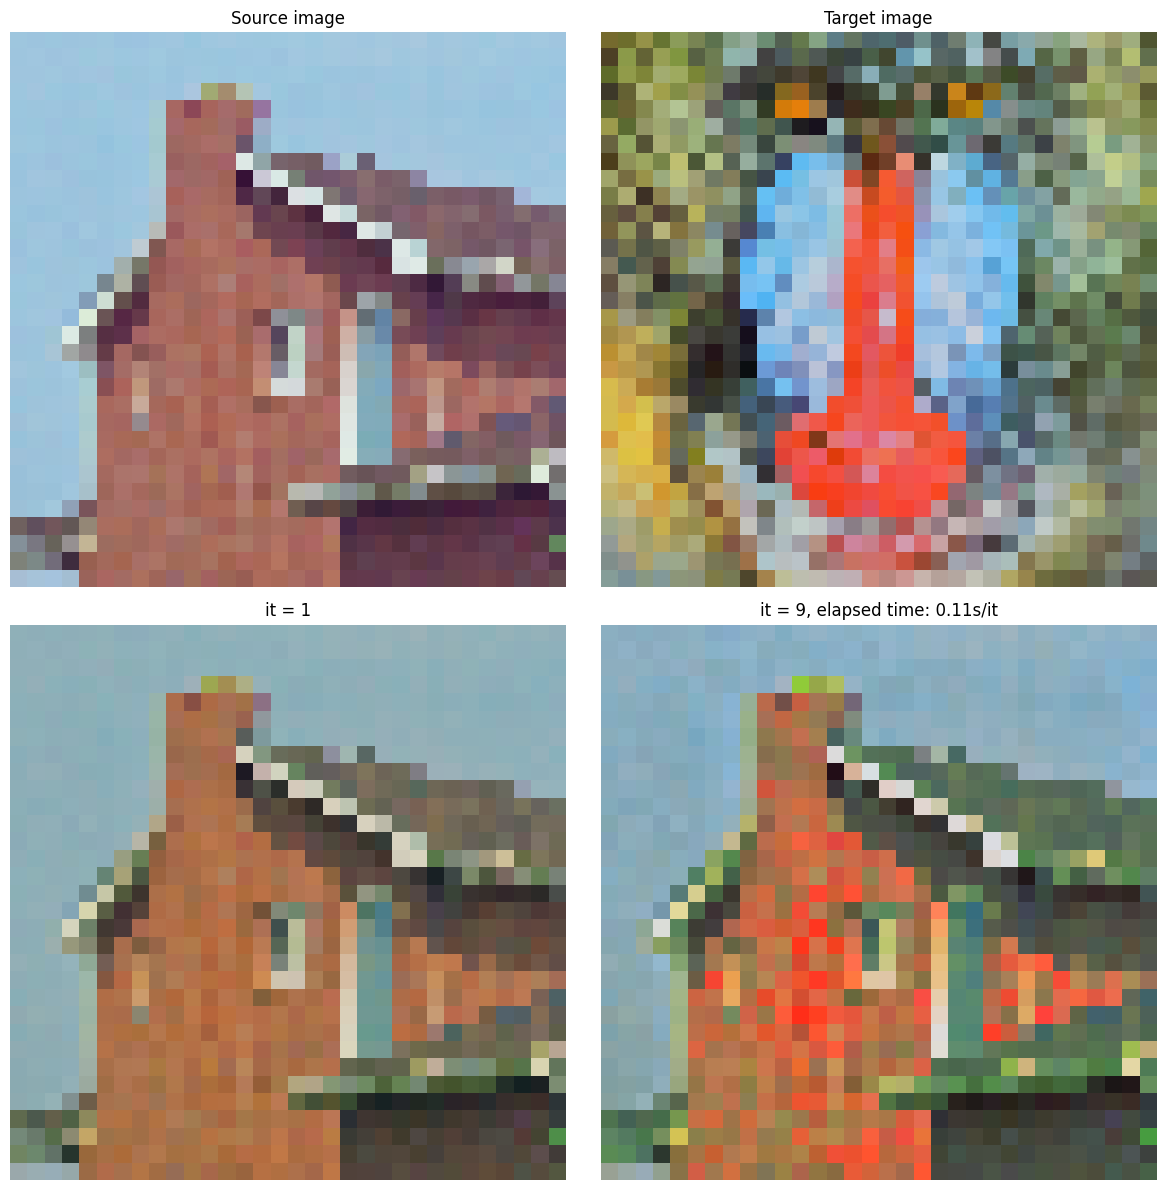

In [26]:
"""
Sinkhorn divergence, which interpolates between 
Wasserstein (blur=0) and kernel (blur= +inf ) distances.
"""
color_transfer(SamplesLoss("sinkhorn", blur=0.3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


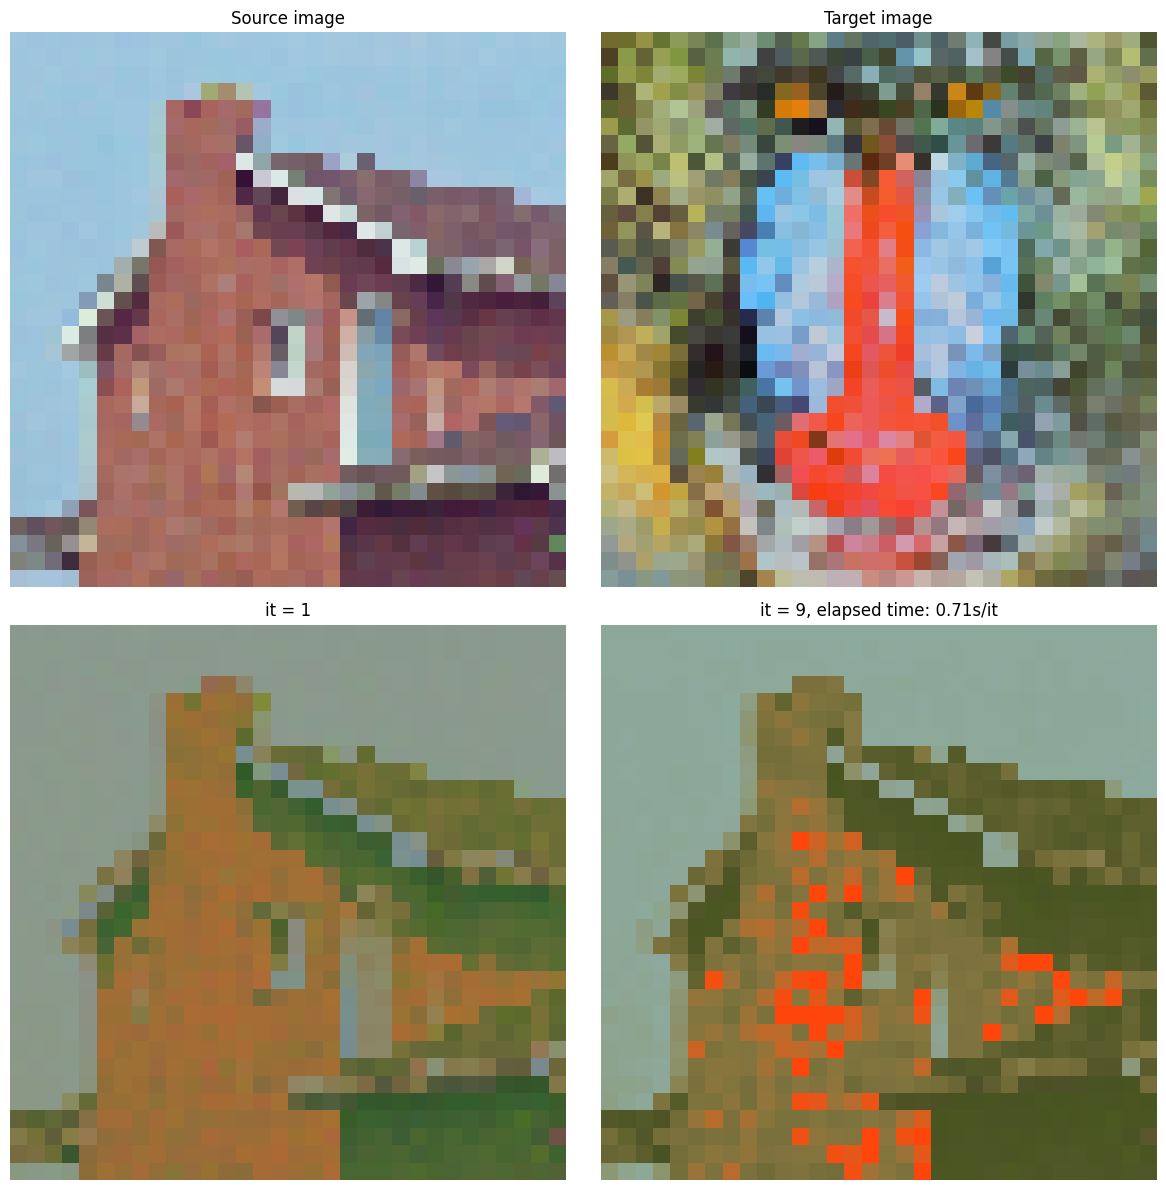

In [23]:
# eps = blur^p
# blur: 0.05
# p: 2
# color_transfer_sinkhorn(eps=0.05**2) # black
color_transfer_sinkhorn(num_steps=10, eps=0.1, p=2)

In [55]:
# color_transfer(SamplesLoss("sinkhorn", blur=0.3))
# color_transfer(SamplesLoss("sinkhorn", blur=0.1))
# color_transfer(SamplesLoss("sinkhorn", blur=0.1, reach=0.4))
# color_transfer(SamplesLoss("sinkhorn", p=1, blur=0.3))
# plt.show()